In [3]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import os 
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import geopandas as gpd
import contextily as ctx

In [4]:
yesterday_date = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')
yesterday_date

'2024-03-19'

In [5]:
dialect = 'mysql+pymysql'
user = 'root'
password = os.getenv('mdp_mySQL')
host = 'localhost'
port = 3306
database_idf = 'SNCF_TGV_TER'

engine_url = f"{dialect}://{user}:{password}@{host}:{port}/{database_idf}"
engine = create_engine(engine_url)

In [6]:
query_disruption = f"""
SELECT * FROM disruptions_tgv_ter
WHERE data_date = '{yesterday_date}'
"""

df_disruption = pd.read_sql_query(query_disruption, engine)
df_disruption

,id_disruption,vehicle_id,train_type,id_stop,name_stop,lon,lat,disruption_start,disruption_end,arrival_delay,departure_delay,cause_delay,data_date
0,2f7ca0ad-3f74-4958-bbfe-502446bcdec5,SNCF:2024-03-19:12244:1187:LongDistanceTrain,TGV,stop_point:SNCF:87391003:LongDistanceTrain,Paris - Montparnasse - Hall 1 & 2,2.320510,48.8412,2024-03-19 18:46:00,2024-03-19 21:04:00,5.0,5.0,Intervention des forces de l'ordre,2024-03-19
1,2f7ca0ad-3f74-4958-bbfe-502446bcdec5,SNCF:2024-03-19:12244:1187:LongDistanceTrain,TGV,stop_point:SNCF:87393702:LongDistanceTrain,Massy TGV,2.261250,48.7258,2024-03-19 18:46:00,2024-03-19 21:04:00,10.0,10.0,Intervention des forces de l'ordre,2024-03-19
2,2f7ca0ad-3f74-4958-bbfe-502446bcdec5,SNCF:2024-03-19:12244:1187:LongDistanceTrain,TGV,stop_point:SNCF:87581009:LongDistanceTrain,Bordeaux Saint-Jean,-0.556697,44.8259,2024-03-19 18:46:00,2024-03-19 21:04:00,10.0,10.0,Intervention des forces de l'ordre,2024-03-19
3,bc7038da-a633-4418-9ed8-5d9cf6bdd5fe,SNCF:2024-03-19:12255:1187:LongDistanceTrain,TGV,stop_point:SNCF:87391003:LongDistanceTrain,Paris - Montparnasse - Hall 1 & 2,2.320510,48.8412,2024-03-19 11:04:00,2024-03-19 13:24:00,50.0,50.0,Travaux sur les voies,2024-03-19
4,bc7038da-a633-4418-9ed8-5d9cf6bdd5fe,SNCF:2024-03-19:12255:1187:LongDistanceTrain,TGV,stop_point:SNCF:87581009:LongDistanceTrain,Bordeaux Saint-Jean,-0.556697,44.8259,2024-03-19 11:04:00,2024-03-19 13:24:00,10.0,10.0,Travaux sur les voies,2024-03-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6487,ae66e197-9f22-4626-8ca8-45c4338b4c05,SNCF:2024-03-19:9882:1187:LongDistanceTrain,TGV,stop_point:SNCF:87318964:LongDistanceTrain,Avignon TGV,4.786140,43.9219,2024-03-19 17:12:00,2024-03-19 22:48:00,5.0,5.0,Incident de circulation,2024-03-19
6488,ae66e197-9f22-4626-8ca8-45c4338b4c05,SNCF:2024-03-19:9882:1187:LongDistanceTrain,TGV,stop_point:SNCF:87319012:LongDistanceTrain,Aix-en-Provence TGV,5.317530,43.4552,2024-03-19 17:12:00,2024-03-19 22:48:00,5.0,5.0,Incident de circulation,2024-03-19
6489,ae66e197-9f22-4626-8ca8-45c4338b4c05,SNCF:2024-03-19:9882:1187:LongDistanceTrain,TGV,stop_point:SNCF:87723197:LongDistanceTrain,Lyon Part Dieu,4.859410,45.7606,2024-03-19 17:12:00,2024-03-19 22:48:00,5.0,10.0,Incident de circulation,2024-03-19
6490,ae66e197-9f22-4626-8ca8-45c4338b4c05,SNCF:2024-03-19:9882:1187:LongDistanceTrain,TGV,stop_point:SNCF:87751008:LongDistanceTrain,Marseille Saint-Charles,5.380410,43.3027,2024-03-19 17:12:00,2024-03-19 22:48:00,0.0,0.0,Incident de circulation,2024-03-19


In [7]:
query_vehicle = f"""
SELECT * FROM vehicle_journeys_tgv_ter
WHERE data_date = '{yesterday_date}'
"""

df_vehicle = pd.read_sql_query(query_vehicle, engine)
df_vehicle

,vehicle_id,route_id,time_begin,time_end,train_type,id_disruption,data_date
0,vehicle_journey:SNCF:2024-03-19:12244:1187:Lon...,route:SNCF:CSR:421400,0 days 18:46:00,0 days 20:59:00,Train grande vitesse,2f7ca0ad-3f74-4958-bbfe-502446bcdec5,2024-03-19
1,vehicle_journey:SNCF:2024-03-19:12251:1187:Lon...,route:SNCF:CSR:421400,0 days 07:04:00,0 days 09:14:00,Train grande vitesse,None,2024-03-19
2,vehicle_journey:SNCF:2024-03-19:12254:1187:Lon...,route:SNCF:CSR:421400,0 days 10:46:00,0 days 12:53:00,Train grande vitesse,0fad94ce-c19b-426b-822b-10eb449dba7c,2024-03-19
3,vehicle_journey:SNCF:2024-03-19:12255:1187:Lon...,route:SNCF:CSR:421400,0 days 11:04:00,0 days 13:14:00,Train grande vitesse,bc7038da-a633-4418-9ed8-5d9cf6bdd5fe,2024-03-19
4,vehicle_journey:SNCF:2024-03-19:12258:1187:Lon...,route:SNCF:CSR:421400,0 days 13:46:00,0 days 15:53:00,Train grande vitesse,None,2024-03-19
...,...,...,...,...,...,...,...
8905,vehicle_journey:SNCF:2024-03-19:9890:1187:Long...,route:SNCF:CSR:005400,0 days 05:59:00,0 days 09:43:00,Train grande vitesse,None,2024-03-19
8906,vehicle_journey:SNCF:2024-03-19:9894:1187:Long...,route:SNCF:CSR:005400,0 days 17:01:00,0 days 21:01:00,Train grande vitesse,54c85af4-69b0-4b60-bbb8-8738af416524,2024-03-19
8907,vehicle_journey:SNCF:2024-03-19:9896:1187:Long...,route:SNCF:CSR:071100,0 days 15:56:00,0 days 23:49:00,Train grande vitesse,None,2024-03-19
8908,vehicle_journey:SNCF:2024-03-19:9898:1187:Long...,route:SNCF:CSR:071200,0 days 06:31:00,0 days 14:15:00,Train grande vitesse,None,2024-03-19


In [8]:
df_lines = pd.read_sql_table('pt_lines_tgv_ter', engine)
df_lines

,route_id,route_name,train_type,network_name,opening_time,closing_time
0,route:SNCF:0018-80100537-87271007,Dortmund Hbf - Paris Nord,Train grande vitesse,Eurostar,05:18:00,12:21:00
1,route:SNCF:0018-80101840-87271007,Essen Hbf - Paris Nord,Train grande vitesse,Eurostar,07:35:00,22:14:00
2,route:SNCF:0018-80154583-87271007,Köln - Hauptbahnhof - Paris Nord,Train grande vitesse,Eurostar,05:21:00,23:14:00
3,route:SNCF:0018-84000588-87111849,Amsterdam Centraal - Marne-la-Vallée - Chessy,Train grande vitesse,Eurostar,06:47:00,11:05:00
4,route:SNCF:0018-84000588-87271007,Amsterdam Centraal - Paris Nord,Train grande vitesse,Eurostar,06:11:00,23:43:00
...,...,...,...,...,...,...
363,route:stop_area:SNCF:87113001_stop_area:SNCF:8...,Paris Est - Strasbourg,Train grande vitesse,additional service,None,None
364,route:stop_area:SNCF:87394007_stop_area:SNCF:8...,Chartres - Versailles Chantiers,Train grande vitesse,additional service,None,None
365,route:stop_area:SNCF:87411017_stop_area:SNCF:8...,Rouen Rive Droite - Paris Saint-Lazare,Train grande vitesse,additional service,None,None
366,route:stop_area:SNCF:87411017_stop_area:SNCF:8...,Rouen Rive Droite - Le Havre,Train grande vitesse,additional service,None,None


# NOMBRE DE PERTURBATION

In [9]:
nb_disruption = len(df_disruption['id_disruption'].unique())
print("nombre de perturbation : " + str(nb_disruption))

nombre de perturbation : 743


# POURCENTAGE TRAJET IMPACTE

In [10]:
nb_vehicle_journeys = len(df_vehicle)
print("nombre de trajet : " + str(nb_vehicle_journeys))

impacted_journeys = df_vehicle['id_disruption'].notnull().sum()
print("nombre de trajet impacté : " + str(impacted_journeys))

per_impacted = impacted_journeys/nb_vehicle_journeys*100
print("pourcentage de trajet impacté : " + str(round(per_impacted,2)) + "%")

nombre de trajet : 8910
nombre de trajet impacté : 1286
pourcentage de trajet impacté : 14.43%


# Temps total de perturbation


In [11]:
df_disruption['duration'] = df_disruption['disruption_end'] - df_disruption['disruption_start']
df_disruption_unique = df_disruption[~df_disruption.duplicated(subset=['id_disruption'], keep='first')]
total_disruption_duration =  df_disruption_unique['duration'].sum()
print("temps cumulé de perturbation : " +  str(total_disruption_duration))

temps cumulé de perturbation : 58 days 20:17:30


# Information sur la première perturbation de la journée

In [12]:
df_vehicle['vehicle_id'] = df_vehicle['vehicle_id'].apply(lambda x: ':'.join(x.split(':')[1:]))
df_vehicle

,vehicle_id,route_id,time_begin,time_end,train_type,id_disruption,data_date
0,SNCF:2024-03-19:12244:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 18:46:00,0 days 20:59:00,Train grande vitesse,2f7ca0ad-3f74-4958-bbfe-502446bcdec5,2024-03-19
1,SNCF:2024-03-19:12251:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 07:04:00,0 days 09:14:00,Train grande vitesse,None,2024-03-19
2,SNCF:2024-03-19:12254:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 10:46:00,0 days 12:53:00,Train grande vitesse,0fad94ce-c19b-426b-822b-10eb449dba7c,2024-03-19
3,SNCF:2024-03-19:12255:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 11:04:00,0 days 13:14:00,Train grande vitesse,bc7038da-a633-4418-9ed8-5d9cf6bdd5fe,2024-03-19
4,SNCF:2024-03-19:12258:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 13:46:00,0 days 15:53:00,Train grande vitesse,None,2024-03-19
...,...,...,...,...,...,...,...
8905,SNCF:2024-03-19:9890:1187:LongDistanceTrain,route:SNCF:CSR:005400,0 days 05:59:00,0 days 09:43:00,Train grande vitesse,None,2024-03-19
8906,SNCF:2024-03-19:9894:1187:LongDistanceTrain,route:SNCF:CSR:005400,0 days 17:01:00,0 days 21:01:00,Train grande vitesse,54c85af4-69b0-4b60-bbb8-8738af416524,2024-03-19
8907,SNCF:2024-03-19:9896:1187:LongDistanceTrain,route:SNCF:CSR:071100,0 days 15:56:00,0 days 23:49:00,Train grande vitesse,None,2024-03-19
8908,SNCF:2024-03-19:9898:1187:LongDistanceTrain,route:SNCF:CSR:071200,0 days 06:31:00,0 days 14:15:00,Train grande vitesse,None,2024-03-19


In [13]:
df_merge_inter = pd.merge(df_disruption, df_vehicle[['route_id', 'vehicle_id']], on='vehicle_id', how='left')
df_disruption_merge = pd.merge(df_merge_inter, df_lines[['route_id', 'route_name', 'network_name']], on='route_id', how='left')
df_disruption_merge

,id_disruption,vehicle_id,train_type,id_stop,name_stop,lon,lat,disruption_start,disruption_end,arrival_delay,departure_delay,cause_delay,data_date,duration,route_id,route_name,network_name
0,2f7ca0ad-3f74-4958-bbfe-502446bcdec5,SNCF:2024-03-19:12244:1187:LongDistanceTrain,TGV,stop_point:SNCF:87391003:LongDistanceTrain,Paris - Montparnasse - Hall 1 & 2,2.320510,48.8412,2024-03-19 18:46:00,2024-03-19 21:04:00,5.0,5.0,Intervention des forces de l'ordre,2024-03-19,0 days 02:18:00,route:SNCF:CSR:421400,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
1,2f7ca0ad-3f74-4958-bbfe-502446bcdec5,SNCF:2024-03-19:12244:1187:LongDistanceTrain,TGV,stop_point:SNCF:87393702:LongDistanceTrain,Massy TGV,2.261250,48.7258,2024-03-19 18:46:00,2024-03-19 21:04:00,10.0,10.0,Intervention des forces de l'ordre,2024-03-19,0 days 02:18:00,route:SNCF:CSR:421400,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
2,2f7ca0ad-3f74-4958-bbfe-502446bcdec5,SNCF:2024-03-19:12244:1187:LongDistanceTrain,TGV,stop_point:SNCF:87581009:LongDistanceTrain,Bordeaux Saint-Jean,-0.556697,44.8259,2024-03-19 18:46:00,2024-03-19 21:04:00,10.0,10.0,Intervention des forces de l'ordre,2024-03-19,0 days 02:18:00,route:SNCF:CSR:421400,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
3,bc7038da-a633-4418-9ed8-5d9cf6bdd5fe,SNCF:2024-03-19:12255:1187:LongDistanceTrain,TGV,stop_point:SNCF:87391003:LongDistanceTrain,Paris - Montparnasse - Hall 1 & 2,2.320510,48.8412,2024-03-19 11:04:00,2024-03-19 13:24:00,50.0,50.0,Travaux sur les voies,2024-03-19,0 days 02:20:00,route:SNCF:CSR:421400,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
4,bc7038da-a633-4418-9ed8-5d9cf6bdd5fe,SNCF:2024-03-19:12255:1187:LongDistanceTrain,TGV,stop_point:SNCF:87581009:LongDistanceTrain,Bordeaux Saint-Jean,-0.556697,44.8259,2024-03-19 11:04:00,2024-03-19 13:24:00,10.0,10.0,Travaux sur les voies,2024-03-19,0 days 02:20:00,route:SNCF:CSR:421400,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6487,ae66e197-9f22-4626-8ca8-45c4338b4c05,SNCF:2024-03-19:9882:1187:LongDistanceTrain,TGV,stop_point:SNCF:87318964:LongDistanceTrain,Avignon TGV,4.786140,43.9219,2024-03-19 17:12:00,2024-03-19 22:48:00,5.0,5.0,Incident de circulation,2024-03-19,0 days 05:36:00,route:SNCF:CSR:001200,Marseille Saint-Charles - Bruxelles-Midi / Bru...,TGV INOUI
6488,ae66e197-9f22-4626-8ca8-45c4338b4c05,SNCF:2024-03-19:9882:1187:LongDistanceTrain,TGV,stop_point:SNCF:87319012:LongDistanceTrain,Aix-en-Provence TGV,5.317530,43.4552,2024-03-19 17:12:00,2024-03-19 22:48:00,5.0,5.0,Incident de circulation,2024-03-19,0 days 05:36:00,route:SNCF:CSR:001200,Marseille Saint-Charles - Bruxelles-Midi / Bru...,TGV INOUI
6489,ae66e197-9f22-4626-8ca8-45c4338b4c05,SNCF:2024-03-19:9882:1187:LongDistanceTrain,TGV,stop_point:SNCF:87723197:LongDistanceTrain,Lyon Part Dieu,4.859410,45.7606,2024-03-19 17:12:00,2024-03-19 22:48:00,5.0,10.0,Incident de circulation,2024-03-19,0 days 05:36:00,route:SNCF:CSR:001200,Marseille Saint-Charles - Bruxelles-Midi / Bru...,TGV INOUI
6490,ae66e197-9f22-4626-8ca8-45c4338b4c05,SNCF:2024-03-19:9882:1187:LongDistanceTrain,TGV,stop_point:SNCF:87751008:LongDistanceTrain,Marseille Saint-Charles,5.380410,43.3027,2024-03-19 17:12:00,2024-03-19 22:48:00,0.0,0.0,Incident de circulation,2024-03-19,0 days 05:36:00,route:SNCF:CSR:001200,Marseille Saint-Charles - Bruxelles-Midi / Bru...,TGV INOUI


In [14]:
index_first_disruption = df_disruption_merge.loc[df_disruption_merge['disruption_start'] >= yesterday_date]['disruption_start'].idxmin()

hour_first_disruption = df_disruption_merge['disruption_start'][index_first_disruption]
print("horraire de la première perturbation de la journée : " + str(hour_first_disruption))

cause_first_disruption = df_disruption_merge['cause_delay'][index_first_disruption]
print("cause de la perturbation : " + str(cause_first_disruption))

route_first_disruption = df_disruption_merge['route_name'][index_first_disruption]
print("nom de la ligne impactée : " + str(route_first_disruption))

network_first_disruption = df_disruption_merge['network_name'][index_first_disruption]
print("réseau : " + str(network_first_disruption))

horraire de la première perturbation de la journée : 2024-03-19 04:56:00
cause de la perturbation : Travaux sur les voies
nom de la ligne impactée : nan
réseau : nan


# Réseaux les plus perturbés en pourcentage (test graphique)


In [35]:
df_vehicle_merge = pd.merge(df_vehicle, df_lines[['route_id', 'route_name', 'network_name']], on='route_id', how='left')
df_vehicle_merge

,vehicle_id,route_id,time_begin,time_end,train_type,id_disruption,data_date,route_name,network_name
0,SNCF:2024-03-19:12244:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 18:46:00,0 days 20:59:00,Train grande vitesse,2f7ca0ad-3f74-4958-bbfe-502446bcdec5,2024-03-19,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
1,SNCF:2024-03-19:12251:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 07:04:00,0 days 09:14:00,Train grande vitesse,None,2024-03-19,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
2,SNCF:2024-03-19:12254:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 10:46:00,0 days 12:53:00,Train grande vitesse,0fad94ce-c19b-426b-822b-10eb449dba7c,2024-03-19,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
3,SNCF:2024-03-19:12255:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 11:04:00,0 days 13:14:00,Train grande vitesse,bc7038da-a633-4418-9ed8-5d9cf6bdd5fe,2024-03-19,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
4,SNCF:2024-03-19:12258:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 13:46:00,0 days 15:53:00,Train grande vitesse,None,2024-03-19,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
...,...,...,...,...,...,...,...,...,...
8905,SNCF:2024-03-19:9890:1187:LongDistanceTrain,route:SNCF:CSR:005400,0 days 05:59:00,0 days 09:43:00,Train grande vitesse,None,2024-03-19,Strasbourg - Bruxelles-Midi / Brussel-Zuid,TGV INOUI
8906,SNCF:2024-03-19:9894:1187:LongDistanceTrain,route:SNCF:CSR:005400,0 days 17:01:00,0 days 21:01:00,Train grande vitesse,54c85af4-69b0-4b60-bbb8-8738af416524,2024-03-19,Strasbourg - Bruxelles-Midi / Brussel-Zuid,TGV INOUI
8907,SNCF:2024-03-19:9896:1187:LongDistanceTrain,route:SNCF:CSR:071100,0 days 15:56:00,0 days 23:49:00,Train grande vitesse,None,2024-03-19,Nancy - Nice,TGV INOUI
8908,SNCF:2024-03-19:9898:1187:LongDistanceTrain,route:SNCF:CSR:071200,0 days 06:31:00,0 days 14:15:00,Train grande vitesse,None,2024-03-19,Montpellier Saint-Roch - Strasbourg,TGV INOUI


In [36]:
vehicle_by_network = df_vehicle_merge.groupby('network_name')['vehicle_id'].count()
vehicle_by_network

network_name
DB SNCF                    60
Eurostar                  104
Intercités                 48
Intercités de nuit          4
LEX                       111
OUIGO                      54
OUIGO Train Classique       5
TER                      3055
TER HDF                   367
TER NA                    233
TGV INOUI                 551
TGV Lyria                  31
Name: vehicle_id, dtype: int64

In [34]:
disrupted_vehicle_by_network = df_vehicle_merge[df_vehicle_merge['id_disruption'].notna()].groupby('network_name')['vehicle_id'].count()

for name in vehicle_by_network.index:
    if not(name in disrupted_vehicle_by_network.index):
        disrupted_vehicle_by_network[name] = 0
        
disrupted_vehicle_by_network

network_name
DB SNCF                    8
Eurostar                   1
Intercités                 9
Intercités de nuit         2
LEX                        3
OUIGO                     15
OUIGO Train Classique      2
TER                      390
TER HDF                  124
TER NA                    38
TGV INOUI                111
TGV Lyria                  6
Name: vehicle_id, dtype: int64

In [18]:
per_disrupted_vehicle_by_network = (disrupted_vehicle_by_network/vehicle_by_network *100).where(disrupted_vehicle_by_network >= 1, 0).sort_values(ascending=True)
per_disrupted_vehicle_by_network

network_name
Eurostar                  0.961538
LEX                       2.702703
TER                      12.765957
DB SNCF                  13.333333
TER NA                   16.309013
Intercités               18.750000
TGV Lyria                19.354839
TGV INOUI                20.145191
OUIGO                    27.777778
TER HDF                  33.787466
OUIGO Train Classique    40.000000
Intercités de nuit       50.000000
Name: vehicle_id, dtype: float64

In [50]:
df_disruption_merge['time_disruption'] = df_disruption_merge['disruption_end'] - df_disruption_merge['disruption_start']

In [108]:
#Transformer en minutes éventuellement

avg_dellay_by_network = df_disruption_merge.drop_duplicates(['id_disruption', 'vehicle_id']).groupby('network_name')['arrival_delay'].sum()/vehicle_by_network

for i in range(len(avg_dellay_by_network)):
    avg_dellay_by_network[i] = str(int(avg_dellay_by_network[i]*60)) + " secondes" 
    
print("temps moyen de retard par train en seconde pour chaque réseau : \n\n" + str(avg_dellay_by_network))

temps moyen de retard par train en seconde pour chaque réseau : 

network_name
DB SNCF                   70 secondes
Eurostar                   8 secondes
Intercités                43 secondes
Intercités de nuit        75 secondes
LEX                        8 secondes
OUIGO                    216 secondes
OUIGO Train Classique    120 secondes
TER                       17 secondes
TER HDF                  103 secondes
TER NA                    81 secondes
TGV INOUI                 89 secondes
TGV Lyria                106 secondes
dtype: object


In [110]:
# Je n'ai pas encore décidé des informations à présenter, c'est pourquoi il y a des répétitions
info = [vehicle_by_network,disrupted_vehicle_by_network,avg_dellay_by_network,disrupted_vehicle_by_network]
info_name = ["Nombre de trajet", "Nombre de trajet \n perturbé", "Retard moyen \n par train", "?"]

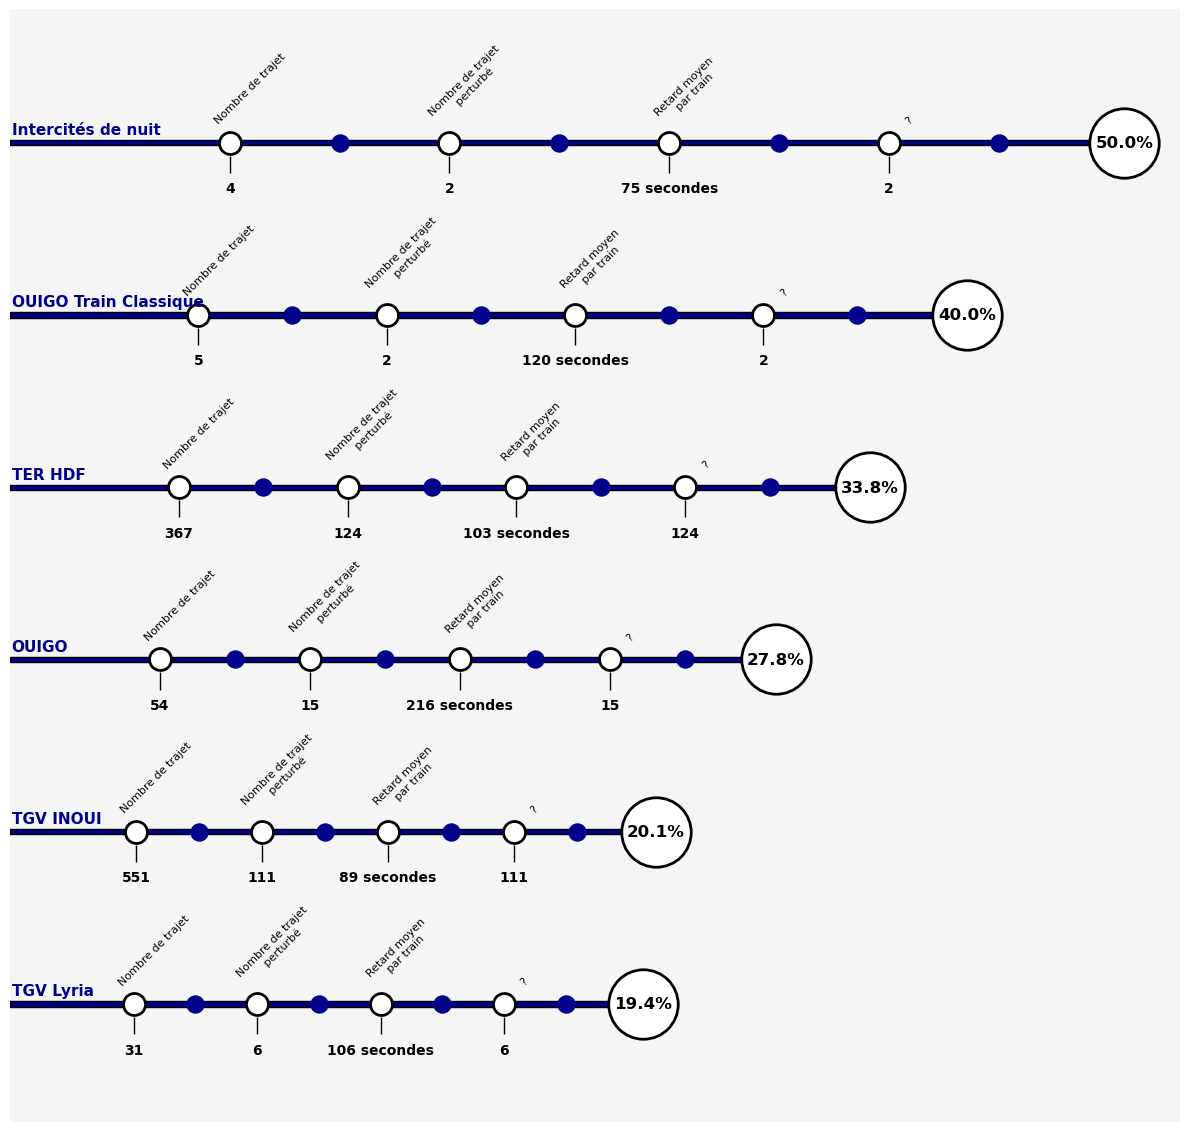

In [111]:
# Je n'ai pas encore décidé des informations à présenter, c'est pourquoi il y a des répétitions

per_disrupted_vehicle_by_network_part1 = dict(per_disrupted_vehicle_by_network[6:])

fig, ax = plt.subplots(figsize=(12, 12))

transformation = {key: (value+20)*0.1 for key, value in per_disrupted_vehicle_by_network_part1.items()}

keys = list(transformation.keys())
values = list(transformation.values())

bars = ax.barh(keys, values, color='darkblue', edgecolor='black', height=0.03)

x_positions = [value + 0.1 for value in values]

ax.scatter(x_positions, list(transformation.keys()), facecolors='white', edgecolors='black', linewidths=2, s=2500)

intervals_white = [0.2, 0.4, 0.6, 0.8]
intervals_black = [0.3, 0.5, 0.7, 0.9]

for j, (bar, new_x) in enumerate(zip(bars, x_positions)):
    y = bar.get_y() + bar.get_height() / 2
    width = bar.get_width()
    
    # Texte pour le pourcentage à droite
    ax.text(new_x, y, f'{width/0.1 - 20:.1f}%', ha='center', va='center', fontsize=12, fontweight='bold')
    
    # Placement des noms des réseaux au début de chaque barre.
    ax.text(0.01, y+0.075, keys[j], ha='left', va='center', fontsize=11, fontweight='bold', color='darkblue')
    
    for i, interval in enumerate(intervals_white):
        circle_x = width * interval
        ax.scatter(circle_x, y, facecolors='white', edgecolors='black', linewidths=2, s=250)
        
        line_start = y - 0.075
        line_end = y - 0.175
        ax.vlines(circle_x, line_start, line_end, colors='black', linewidth=1)
        
        # Texte sous la barre verticale
        text_y_position_below = line_end - 0.05
        current_info_value = info[i][keys[j]]
        ax.text(circle_x, text_y_position_below, f'{current_info_value}', ha='center', va='top', fontsize=10, fontweight='bold')
        
        # Texte au-dessus du cercle
        text_y_position_above = y + 0.1 
        above_text = info_name[i]
        ax.text(circle_x + 0.13, text_y_position_above, above_text, ha='center', va='bottom', fontsize=8, rotation=45)
        
    for interval in intervals_black:
        circle_x = width * interval
        ax.scatter(circle_x, y, facecolors='darkblue', s=150)

ax.set_title('', fontsize=22)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ax.set_facecolor('whitesmoke')
sns.despine(left=True, bottom=True, ax=ax, offset=10, trim=True)

plt.tight_layout()
ax.set_ylim(bottom=ax.get_ylim()[0] -0.25, top=ax.get_ylim()[1] +0.5)
plt.savefig("Perturbation_ligne_part1.png", dpi = 300)

plt.show()

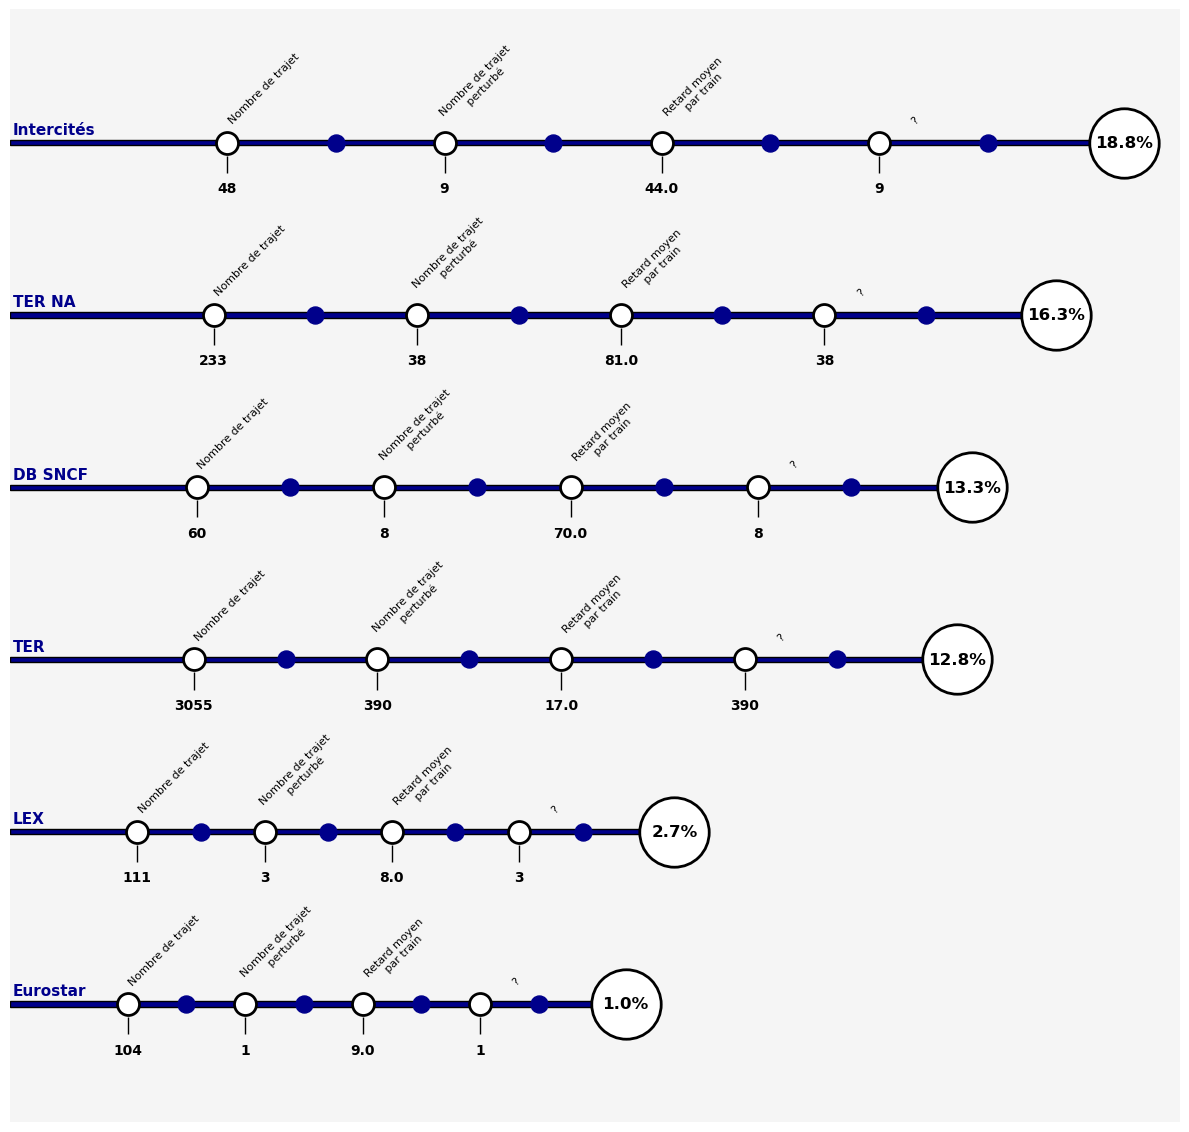

In [101]:
per_disrupted_vehicle_by_network_part2 = dict(per_disrupted_vehicle_by_network[:6])

fig, ax = plt.subplots(figsize=(12, 12))

transformation = {key: (value+20)*0.1 for key, value in per_disrupted_vehicle_by_network_part2.items()}

keys = list(transformation.keys())
values = list(transformation.values())

bars = ax.barh(keys, values, color='darkblue', edgecolor='black', height=0.03)

x_positions = [value + 0.1 for value in values]

ax.scatter(x_positions, list(transformation.keys()), facecolors='white', edgecolors='black', linewidths=2, s=2500)

intervals_white = [0.2, 0.4, 0.6, 0.8]
intervals_black = [0.3, 0.5, 0.7, 0.9]

for j, (bar, new_x) in enumerate(zip(bars, x_positions)):
    y = bar.get_y() + bar.get_height() / 2
    width = bar.get_width()
    
    # Texte pour le pourcentage à droite
    ax.text(new_x, y, f'{width/0.1 - 20:.1f}%', ha='center', va='center', fontsize=12, fontweight='bold')
    
    # Placement des noms des réseaux au début de chaque barre.
    ax.text(0.01, y+0.075, keys[j], ha='left', va='center', fontsize=11, fontweight='bold', color='darkblue')
    
    for i, interval in enumerate(intervals_white):
        circle_x = width * interval
        ax.scatter(circle_x, y, facecolors='white', edgecolors='black', linewidths=2, s=250)
        
        line_start = y - 0.075
        line_end = y - 0.175
        ax.vlines(circle_x, line_start, line_end, colors='black', linewidth=1)
        
        # Texte sous la barre verticale
        text_y_position_below = line_end - 0.05
        current_info_value = info[i][keys[j]]
        ax.text(circle_x, text_y_position_below, f'{current_info_value}', ha='center', va='top', fontsize=10, fontweight='bold')
        
        # Texte au-dessus du cercle
        text_y_position_above = y + 0.1 
        above_text = info_name[i]
        ax.text(circle_x + 0.13, text_y_position_above, above_text, ha='center', va='bottom', fontsize=8, rotation=45)
        
    for interval in intervals_black:
        circle_x = width * interval
        ax.scatter(circle_x, y, facecolors='darkblue', s=150)

ax.set_title('', fontsize=22)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ax.set_facecolor('whitesmoke')
sns.despine(left=True, bottom=True, ax=ax, offset=10, trim=True)

plt.tight_layout()
ax.set_ylim(bottom=ax.get_ylim()[0] -0.25, top=ax.get_ylim()[1] +0.5)
plt.savefig("Perturbation_ligne_part2.png", dpi = 300)

plt.show()

# Routes les plus perturbées en pourcentage (graphique à faire)

In [22]:
vehicle_by_route = df_vehicle_merge.groupby('route_name')['vehicle_id'].count()
vehicle_by_route = vehicle_by_route[vehicle_by_route >= 10]
vehicle_by_route

route_name
(Namur) - (Charleroi) - Maubeuge    14
Alençon - Château Du Loir           12
Ambérieu - Chambery                 12
Amsterdam Centraal - Paris Nord     11
Angers St Laud - Le Mans            25
                                    ..
Tours - Le Croisic                  16
Tours - Saumur - Angers - Nantes    11
Valenciennes - Paris Nord           10
Wissembourg - Neustadt              32
YVETOT - ROUEN - ELBEUF             32
Name: vehicle_id, Length: 171, dtype: int64

In [23]:
disrupted_vehicle_by_route = df_vehicle_merge[df_vehicle_merge['id_disruption'].notna()].groupby('route_name')['vehicle_id'].count()
disrupted_vehicle_by_route

route_name
Alençon - Château Du Loir                        1
Alençon - Le Mans - Tours                        1
Ambérieu - Chambery                              1
Angers St Laud - Le Mans                         4
Annecy - Paris - Gare de Lyon - Hall 1 & 2       2
                                                ..
Tours - Saumur - Bressuire - La Roche sur Yon    1
Tours-Blois-Orléans rapides                      1
Valenciennes - Paris Nord                        1
Wissembourg - Neustadt                           6
YVETOT - ROUEN - ELBEUF                          1
Name: vehicle_id, Length: 206, dtype: int64

In [24]:
per_disrupted_vehicle_by_route = disrupted_vehicle_by_route/vehicle_by_route *100
winners = per_disrupted_vehicle_by_route.sort_values(ascending=True)[:10]
nb_train_winners = vehicle_by_route.loc[winners.index]
print("Les 10 lignes les moins impactées (min 10 trajets)\n\n" + str(winners) + "\n\n\n")
print("Nombre de trajet des 10 lignes les moins impactées\n\n" + str(nb_train_winners))

Les 10 lignes les moins impactées (min 10 trajets)

route_name
L4                                           1.086957
Grasse - Cannes - Nice - Vintimille          1.369863
Annemasse - Suisse                           1.587302
Avignon Tgv - Avignon Centre - Carpentras    1.785714
Lyon Perrache - Firminy                      2.222222
Belfort - Delle                              2.702703
YVETOT - ROUEN - ELBEUF                      3.125000
Les Arcs - Cannes - Nice - Menton            3.571429
CAEN- COUTANCES - GRANVILLE - RENNES         3.846154
Rennes - Montreuil-Sur-L'Ille                4.000000
Name: vehicle_id, dtype: float64



Nombre de trajet des 10 lignes les moins impactées

route_name
L4                                           92
Grasse - Cannes - Nice - Vintimille          73
Annemasse - Suisse                           63
Avignon Tgv - Avignon Centre - Carpentras    56
Lyon Perrache - Firminy                      45
Belfort - Delle                              74
YVETOT - R

In [25]:
losers = per_disrupted_vehicle_by_route.sort_values(ascending=False)[:10]
nb_train_losers = vehicle_by_route.loc[losers.index]
print("Les 10 lignes les plus impactées (min 10 trajets)\n\n" + str(losers) + "\n\n\n")
print("Nombre de trajet des 10 lignes les plus impactées\n\n" + str(nb_train_losers))

Les 10 lignes les plus impactées (min 10 trajets)

route_name
P42                                                        100.000000
C40                                                         74.418605
K40                                                         65.217391
Metz - Sarrebourg                                           60.000000
Toulouse Matabiau - Paris - Montparnasse - Hall 1 & 2       56.250000
Toulouse Matabiau - Port Bou Frontiere                      53.333333
STRASBOURG - BÂLE                                           50.000000
F15                                                         50.000000
Paris - Montparnasse - Hall 1 & 2 - Bordeaux Saint-Jean     48.648649
Strasbourg - Metz                                           45.000000
Name: vehicle_id, dtype: float64



Nombre de trajet des 10 lignes les plus impactées

route_name
P42                                                        20
C40                                                        43
K40             

# Arrêts le plus impactés en nombre et en temps de retard (test graphique)

--> Météo des retards

In [26]:
most_impacted_stop = df_disruption_merge.groupby('name_stop')['vehicle_id'].count().sort_values(ascending=False)[:10]
print("Arrets les plus impactés par les perturbations : \n\n" + str(most_impacted_stop))

Arrets les plus impactés par les perturbations : 

name_stop
Lille Flandres                       77
Bordeaux Saint-Jean                  61
Strasbourg                           53
Douai                                50
Lyon Part Dieu                       48
Paris - Montparnasse - Hall 1 & 2    47
Nantes                               46
Toulouse Matabiau                    45
Metz                                 45
Paris Nord                           36
Name: vehicle_id, dtype: int64


In [27]:
total_disruption_time_by_stop = df_disruption_merge.groupby('name_stop')['departure_delay'].sum().sort_values(ascending=False)[:3]
total_disruption_time_by_stop[0], total_disruption_time_by_stop[1] = total_disruption_time_by_stop[1], total_disruption_time_by_stop[0]
print("Temps total de perturbation aux 3 arrêts le plus impacté : \n\n" + str(total_disruption_time_by_stop))

total_disruption_time_by_stop = dict(total_disruption_time_by_stop)
# Petit problème (ou pas) : Les gares les plus impactées sont surement le plus fréquenté

Temps total de perturbation aux 3 arrêts le plus impacté : 

name_stop
Narbonne          805.0
Douai             930.0
Lille Flandres    680.0
Name: departure_delay, dtype: float64


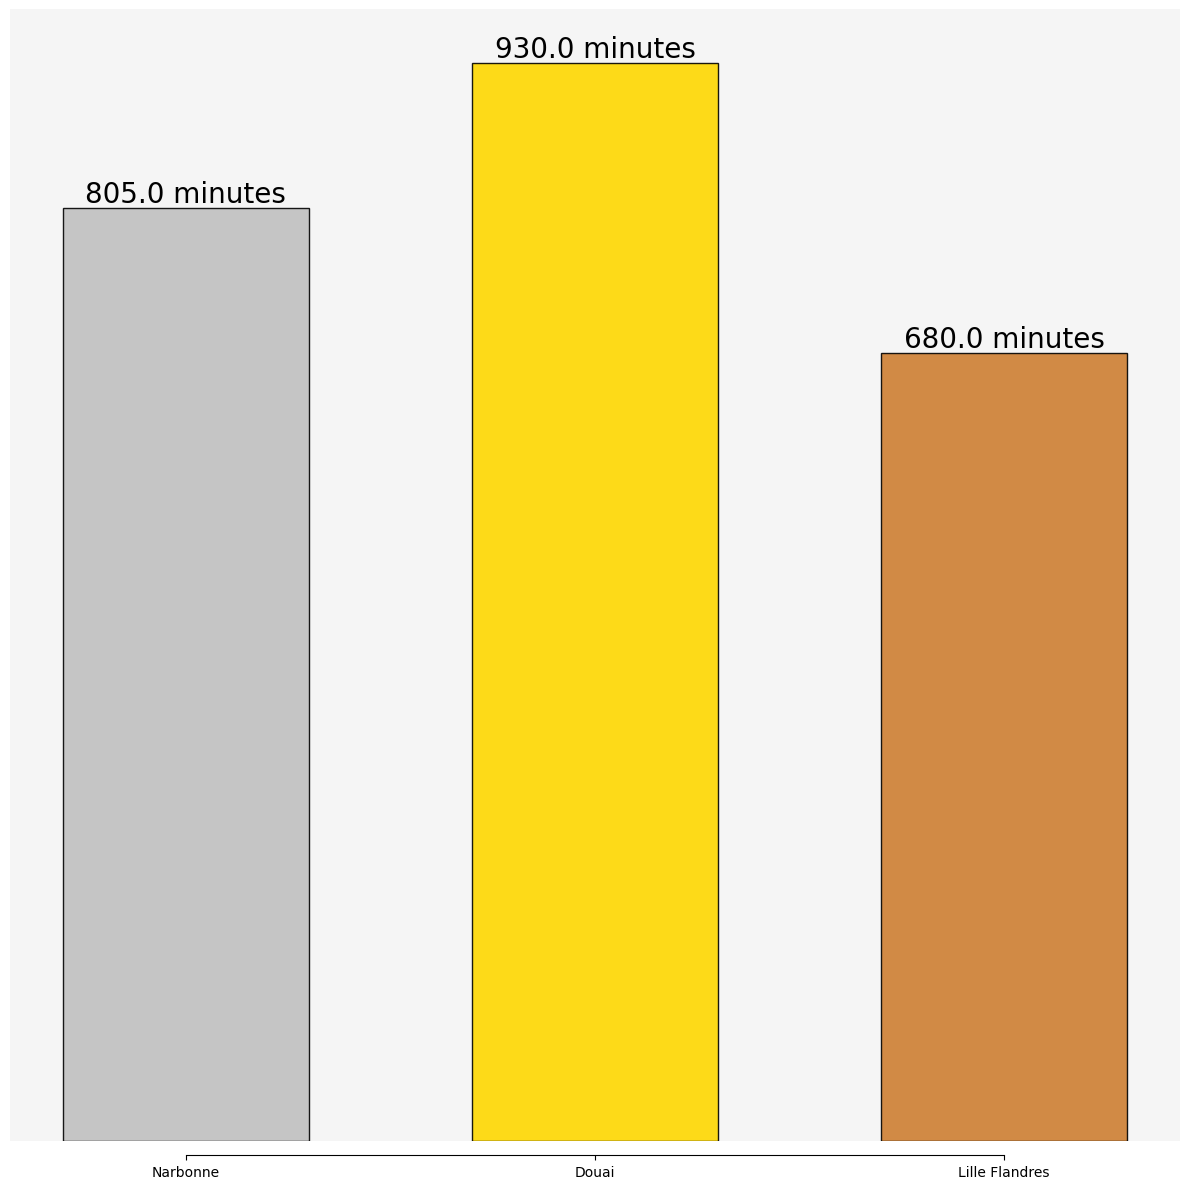

In [28]:
fig, ax = plt.subplots(figsize=(12, 12))

colors = ['#C0C0C0','#FFD700', '#CD7F32']
bars = ax.bar(total_disruption_time_by_stop.keys(), total_disruption_time_by_stop.values(), color=colors, edgecolor='black', width=0.6, alpha = 0.9, zorder=1)

ax.set_title('', fontsize=40)
ax.axes.get_yaxis().set_visible(False)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2., height, f'{height} minutes', ha='center', va='bottom', fontsize=20)

ax.set_facecolor('whitesmoke')
sns.despine(left=True, ax=ax, offset=10, trim=True)
plt.tight_layout()

plt.show()

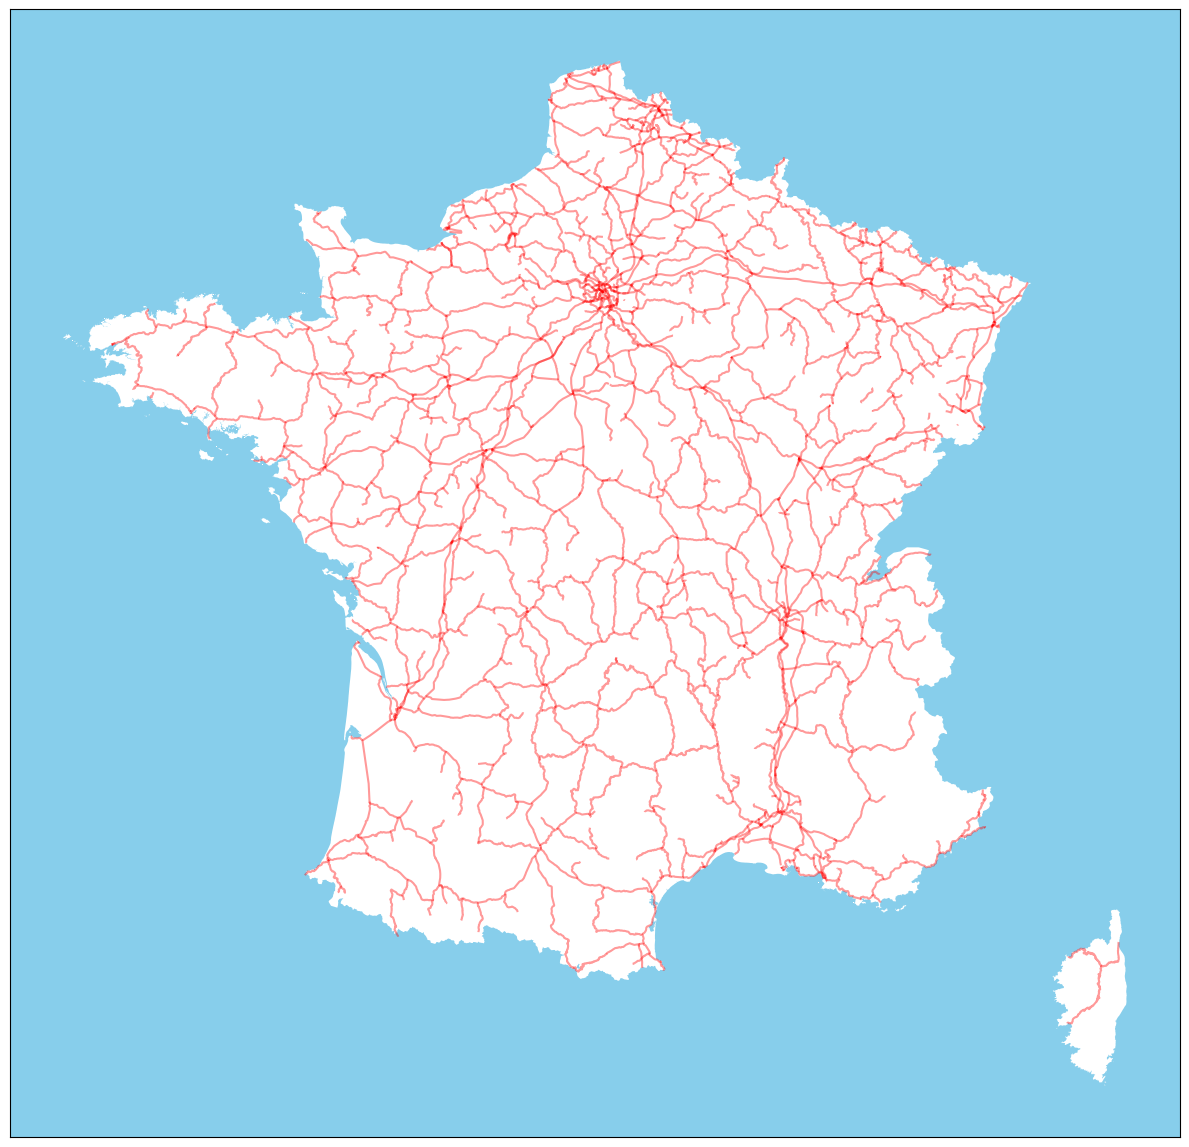

In [29]:
# En rouge c'est le réseau féroviere francais --> ajouter les pays voisins car les données contiennent aussi
# les pays qui partagent une ligne commune avec la France

fig, ax = plt.subplots(figsize=(12, 12))

resau = gpd.read_file('formes-des-lignes-du-rfn/formes-des-lignes-du-rfn.shp')
france = gpd.read_file('data/FRA_adm0.shp')
ax.set_facecolor('skyblue')

france.plot(ax=ax, color='white')
resau.plot(ax=ax, color='red', alpha=0.4)

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.tight_layout()

plt.show()

# Causes de perturbation les plus/moins fréquentes

In [30]:
# En réalité pas de plus ou moins car contient toutes les causes de perturbation
most_causes_disruption = df_disruption_unique.groupby('cause_delay')['id_disruption'].count().sort_values(ascending=True)[:100]
print("cause de perturbation les moins fréquentes de la journée : \n\n" + str(most_causes_disruption))

cause de perturbation les moins fréquentes de la journée : 

cause_delay
Affluence de voyageurs entraînant un arrêt prolongé      1
Assistance à un voyageur                                 1
Confirmation tardive de la voie                          1
Erreur d'itinéraire                                      1
Arrêt exceptionnel en gare                               2
Assistance à un voyageur malade à bord                   2
Modification de matériel                                 3
Indisponibilité d'un matériel                            3
Déclenchement du signal d'alarme                         3
Incident sur un réseau ferré étranger                    4
Intervention des forces de l'ordre                       4
Dérangement d'une installation en gare                   6
Saturation des voies en gare                             7
Défaut d'alimentation électrique                         8
Présence d'animaux sur la voie                           9
Présence d'individus sur les voies        

In [31]:
print("pourcentage d'apparaition de chacune des causes : \n\n" + str(most_causes_disruption/nb_disruption*100))

pourcentage d'apparaition de chacune des causes : 

cause_delay
Affluence de voyageurs entraînant un arrêt prolongé     0.134590
Assistance à un voyageur                                0.134590
Confirmation tardive de la voie                         0.134590
Erreur d'itinéraire                                     0.134590
Arrêt exceptionnel en gare                              0.269179
Assistance à un voyageur malade à bord                  0.269179
Modification de matériel                                0.403769
Indisponibilité d'un matériel                           0.403769
Déclenchement du signal d'alarme                        0.403769
Incident sur un réseau ferré étranger                   0.538358
Intervention des forces de l'ordre                      0.538358
Dérangement d'une installation en gare                  0.807537
Saturation des voies en gare                            0.942127
Défaut d'alimentation électrique                        1.076716
Présence d'animaux sur la 

# Temps de la journée sans perturbation

In [32]:
# Pas pertinent de cette manière --> le faire soit par gare, réseau ou ligne

df_disruption_start_sorted = df_disruption_unique.sort_values(by = 'disruption_start', ascending=True)
df_disruption_start_sorted = df_disruption_start_sorted.reset_index(drop=True)
df_disruption_start_sorted

,id_disruption,vehicle_id,train_type,id_stop,name_stop,lon,lat,disruption_start,disruption_end,arrival_delay,departure_delay,cause_delay,data_date,duration
0,eab5ddac-c7e0-4ba7-b4a3-a8527e7d8591,SNCF:2024-03-19:831700:1187:Train,TER / Intercités,stop_point:SNCF:87212027:Train,Strasbourg,7.73479,48.5845,2024-03-19 04:56:00,2024-03-19 05:43:00,0.0,0.0,Travaux sur les voies,2024-03-19,0 days 00:47:00
1,ba43f860-4bec-4dd5-9c64-f58a658fca7c,SNCF:2024-03-19:864501:1187:Train,TER / Intercités,stop_point:SNCF:87491001:Train,Saintes,-0.61790,45.7487,2024-03-19 05:07:00,2024-03-19 06:22:30,15.0,15.0,Dérangement d'une installation en gare,2024-03-19,0 days 01:15:30
2,c535469d-a8e0-44dd-8547-835ffcb6eaae,SNCF:2024-03-19:831803:1187:Train,TER / Intercités,stop_point:SNCF:87212027:Train,Strasbourg,7.73479,48.5845,2024-03-19 05:09:00,2024-03-19 06:20:00,NaN,0.0,Travaux sur les voies,2024-03-19,0 days 01:11:00
3,e555a00d-2892-4242-8109-fd99b20ac332,SNCF:2024-03-19:96550:1187:Train,TER / Intercités,stop_point:SNCF:85010082:Train,Genève Cornavin,6.14244,46.2102,2024-03-19 05:14:00,2024-03-19 07:27:00,15.0,15.0,Conditions de départ non réunies,2024-03-19,0 days 02:13:00
4,f2ca186e-f3ad-4a4c-9cd2-6c1b830727ee,SNCF:2024-03-19:96201:1187:Train,TER / Intercités,stop_point:SNCF:85000109:Train,Basel SBB,7.58956,47.5474,2024-03-19 05:19:00,2024-03-19 06:38:00,NaN,0.0,Incident de circulation,2024-03-19,0 days 01:19:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,7efbdd6c-700c-4b19-93ef-e03e8ef83d7a,SNCF:2024-03-19:848537:1187:Train,TER / Intercités,stop_point:SNCF:87271007:Train,Paris Nord,2.35485,48.8801,2024-03-19 22:28:00,2024-03-19 23:05:30,0.0,0.0,Régulation du trafic,2024-03-19,0 days 00:37:30
739,9d9a3085-dc6e-45f0-a230-91b41de76b25,SNCF:2024-03-19:848584:1187:Train,TER / Intercités,stop_point:SNCF:87271007:Train,Paris Nord,2.35485,48.8801,2024-03-19 22:29:00,2024-03-19 23:23:00,25.0,25.0,None,2024-03-19,0 days 00:54:00
740,340862c8-193c-467c-b75d-37ca6760e66a,SNCF:2024-03-19:847935:1187:Train,TER / Intercités,stop_point:SNCF:87271007:Train,Paris Nord,2.35485,48.8801,2024-03-19 22:34:00,2024-03-19 23:32:30,0.0,0.0,Présence d'individus sur les voies,2024-03-19,0 days 00:58:30
741,7b6a8164-a5ff-4663-9275-61c901141a4b,SNCF:2024-03-19:23769:1187:Train,TER / Intercités,stop_point:SNCF:87192039:Train,Metz,6.17705,49.1095,2024-03-19 22:38:00,2024-03-19 23:50:00,15.0,15.0,Prise en charge de clients en correspondance,2024-03-19,0 days 01:12:00


In [33]:
time_without_disruption = 0
for t in range(1,len(df_disruption_start_sorted)):
    if df_disruption_start_sorted['disruption_start'][t]> df_disruption_start_sorted['disruption_end'][t-1]:
        time_without_disruption += df_disruption_start_sorted['disruption_start'][t]- df_disruption_start_sorted['disruption_end'][t-1]
            
time_without_disruption

0